In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from boruta import BorutaPy
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load

dna_meth = pd.read_csv("G13_kidney_dna-meth.csv")
gene_expr = pd.read_csv("G13_kidney_gene-expr.csv")
mystery_dna_meth = pd.read_csv("mystery_dna-meth.csv")
mystery_gene_expr = pd.read_csv("mystery_gene-expr.csv")


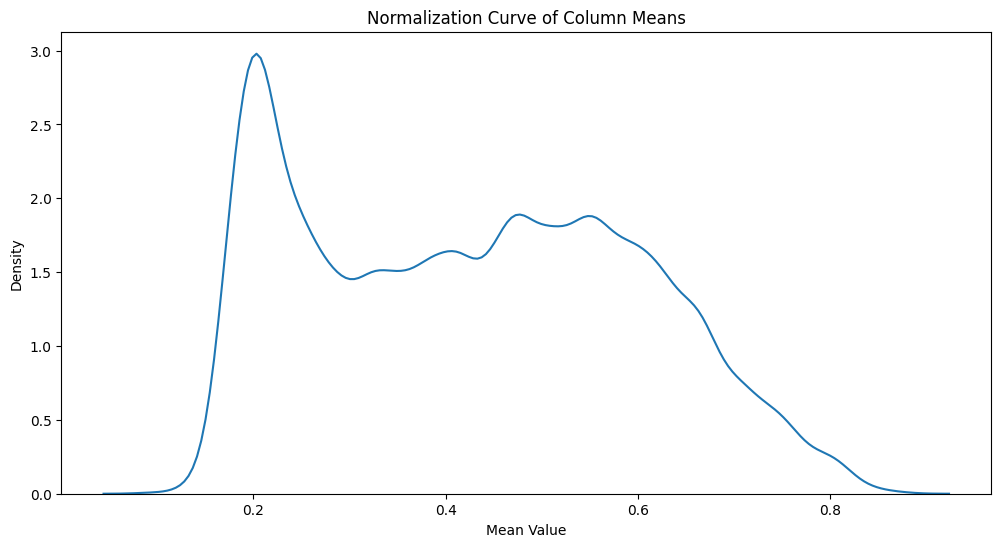

In [14]:
le = LabelEncoder()


numeric_only = dna_meth.select_dtypes(include=['number'])
col_info = dna_meth[numeric_only.columns]

input_data_label = dna_meth['Label'].values
encoded_test = le.fit_transform(input_data_label)
X_train, X_test, y_train, y_test = train_test_split(
    col_info, encoded_test, test_size=0.33, random_state=42)

plt.figure(figsize=(12, 6))
sns.kdeplot(X_train.mean(), bw_adjust=0.5)  # Adjust bw_adjust for smoothing
plt.title('Normalization Curve of Column Means')
plt.xlabel('Mean Value')
plt.ylabel('Density')
plt.show()
scaler = StandardScaler()


In [21]:
class DataProcessor:
    def __init__(self, input_data):
        self.input_data = input_data
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        self.feature_names = None

    def preprocessing(self):
        """
        Preprocess the data to split
        """
        # only select the column with numbers
        numeric_only = self.input_data.select_dtypes(include=['number'])
        col_info = self.input_data[numeric_only.columns]

        self.feature_names = numeric_only.columns.tolist()

        # values of the column label
        input_data_label = self.input_data['Label'].values

        # transform labels to numerical values
        encoded_test = self.le.fit_transform(input_data_label)

        # Split, then normalize, to prevent data leakage. normalize parameter only on 
        # the training/test set independently

        # 33% of data used for testing
        # random state = 42 for reproducibility
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            col_info, encoded_test, test_size=0.33, random_state=42)

        # print (f'X train shape is    {self.X_train.shape}')
        # print (f'y train shape is    {self.y_train.shape}')
        # print (f'X test shape is     {self.X_test.shape}')
        # print (f'y test shape is     {self.y_test.shape}')

    def set_scaler_method(self, method):
        """
        Set the scaler method to use
        :param method: "standard", "minmax", "log"
        if function not run, automatically assume standard
        """
        if method == "standard":
            self.scaler = StandardScaler()
        elif method == "minmax":
            self.scaler = MinMaxScaler()
        elif method == "log":
            self.scaler = FunctionTransformer(np.log1p, validate = True)
        elif isinstance(method, object):
            self.scaler = method
        else:
            print("Invalid scaler method, Defult is standard")

    def scale_data(self):
        plt.figure(figsize=(12, 6))
        sns.kdeplot(self.X_train.mean(), bw_adjust=0.5)  # Adjust bw_adjust for smoothing
        plt.title('Curve of Column Means before Normalization')
        plt.xlabel('Mean Value')
        plt.ylabel('Density')
        plt.show()

        self.scaler.fit(self.X_train)
        self.X_train_scaled = self.scaler.transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        normalized_df = pd.DataFrame(self.X_train_scaled, columns = self.X_train.columns)
        plt.figure(figsize=(12, 6))
        sns.kdeplot(normalized_df.mean(), bw_adjust=0.5)  # Adjust bw_adjust for smoothing
        plt.title('Curve of Column Means after Normalization')
        plt.xlabel('Mean Value')
        plt.ylabel('Density')
        plt.show()

    def feature_selection(self, feature_method, number = None):
        """
        :param feature_method: "RFE", "FeatureImportance", "Boruta", "PCA"
        :param number: Only relevant if feature if RFE, Select number of 
        features to include
        """
        # Initialize the RandomForestClassifier
        self.rf = RandomForestClassifier(n_jobs=-1, 
                                         class_weight='balanced',
                                         n_estimators=50,
                                         max_depth = None,
                                         random_state=42)
        
        # Fit the model first
        self.rf.fit(self.X_train_scaled, self.y_train)

        if feature_method == "RFE":
            self._apply_rfe(number)
        elif feature_method == "FeatureImportance":
            self._apply_FI()
        elif feature_method == "Boruta":
            self._apply_boruta()
        elif feature_method == "PCA":
            self._apply_pca()
        
        # Refit again using the filtered/selected data
        self.rf.fit(self.X_train_selected, self.y_train)


    def _apply_pca(self):
        pca = PCA()
        pca.fit(self.X_train_scaled)

        explained_variance_ratio = pca.explained_variance_ratio_
        # Calculate cumulative explained variance
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(explained_variance_ratio) + 1), 
                 explained_variance_ratio, 
                 marker='o', 
                 linestyle='--')
        plt.title('Explained Variance Ratio by Principal Component')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
        plt.grid(True)
        plt.show()

        # Plot cumulative explained variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), 
                 cumulative_variance_ratio, 
                 marker='o', 
                 linestyle='--')
        plt.title('Cumulative Explained Variance Ratio by Principal Component')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Find number of component meet 95% threshold
        num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
        self.feature = PCA(n_components=num_components)

        self._fit_n_transform()

    def _apply_rfe(self, number):
        # Perform RFE
        self.feature = RFE(self.rf, n_features_to_select = number)
        self._fit_n_transform()

    def _apply_FI(self):
        # Get important features
        importance = self.rf.feature_importances_
        sorted_indicies = importance.argsort()[::-1]

        selected_indicies = sorted_indicies[importance[sorted_indicies] > 0]

        # transform the data
        self.X_train_selected = self.X_train_scaled[:, selected_indicies]
        self.X_test_selected = self.X_test_scaled[:, selected_indicies]

    def _apply_boruta(self):
        self.feature = BorutaPy(estimator = self.rf,
                                n_estimators = "auto",
                                verbose = 2,
                                random_state = 42)
        self._fit_n_transform()
        
    def _fit_n_transform(self):
        # Fit the data and transform to keep selected features
        self.feature.fit(self.X_train_scaled, self.y_train)

        self.X_train_selected = self.feature.transform(self.X_train_scaled)
        self.X_test_selected = self.feature.transform(self.X_test_scaled)

    def feature_selected(self):
        number_of_features = 0
        features_selected = []
        for feature, support in list(zip(self.feature_names,
                                         self.feature.support_)):
            if support: # Count number of features selected by the boruta
                number_of_features += 1
                features_selected.append(feature)
        
        self.features_selected = features_selected
        return number_of_features, features_selected
            
    def model_prediction(self):
        """
        Run the model to predict on the test set and print accuracy
        """

        # Predict on test set and print accuracy score
        self.y_pred = self.rf.predict(self.X_test_selected)
        accuracy = accuracy_score(self.y_test, self.y_pred), 
        report = classification_report(self.y_test, self.y_pred)

        return accuracy, report

    def visualize_importance(self, file_path):
        """Must run feature_selected before visualization"""
        importance = self.rf.feature_importances_
        # Sort the features by importance in descending order
        sorted_indices = importance.argsort()[::-1]
        non_zero_indices = sorted_indices[importance[sorted_indices] > 0]

        # Visualize feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(non_zero_indices)), 
                importance[non_zero_indices])
        plt.xticks(range(len(non_zero_indices)), 
                   [self.features_selected[i] for i in non_zero_indices], 
                   rotation=90)
        plt.xlabel("Features")
        plt.ylabel("Feature Importance")
        plt.title("Feature Importances from the selected method")
        plt.tight_layout()
        
        # Save the plot as a PNG file
        plt.savefig(file_path, format="png")

        # Show the plot
        plt.show()

    def plot_confusion_matrix(self, file_path):
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True)

        # Set labels and Title
        plt.title("Confusion Matrix")

        # Save the heatmap as PNG file
        plt.savefig(file_path, format="png")

        # Show the plot
        plt.show()

        return cm

    def neural_network_model(self, epochs_number = 10000):
        X_train_tensor = torch.tensor(self.X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(self.y_train, dtype=torch.long)

        input_size = self.X_train_scaled.shape[1]
        hidden_size = 64 # Alter later
        num_classes = len(set(self.y_train))

        self.model = NeuralNetwork(input_size, hidden_size, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=0.01)

        train_losses = []
        train_accuracies = []

        # Training Loop
        epochs = epochs_number

        for epoch in range(epochs):
            self.model.train()
            y_pred = self.model(X_train_tensor)
            loss = criterion(y_pred, y_train_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            _,predicted = torch.max(y_pred, 1)
            train_accuracies.append(
                accuracy_score(y_train_tensor.numpy(), predicted.numpy()))

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
        self.model.eval()

        self.train_losses = train_losses
        self.train_accuracies = train_accuracies

        torch.save(self.model.state.dict(), "nnm.pth")
    
    def test_nnm(self):
        X_test_tensor = torch.tensor(self.X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(self.y_test, dtype=torch.long)
        with torch.no_grad():
            y_pred = self.model(X_test_tensor)
            _, predicted_classes = torch.max(y_pred, 1)
            accuracy = accuracy_score(y_test_tensor.numpy(), 
                                      predicted_classes.numpy())
    
        return accuracy
    
    def plot_nnm_result(self, file_path):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()

        plt.savefig(file_path + "training_loss_curve.png", format="png")
        plt.show()
    
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_accuracies, label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()

        plt.savefig(file_path + "Accuracy_curve.png", format="png")
        plt.show()
    
    def predict_eval(self, unknown_data):

        unknown_label = unknown_data['Label'].values
        self.y_test = self.le.fit_transform(unknown_label)

        # Filter the feature to features used to scale model
        unknown_data_filtered = unknown_data[self.feature_names]

        # Scale the unknown data using the established scaled
        self.X_test_scaled = self.scaler.transform(unknown_data_filtered)

        # Transform the unknown data to retain feature selected
        unknown_data_transformed = self.feature.transform(self.X_test_scaled)      

        # Use the model to predict our unknown data
        self.y_pred = self.rf.predict(unknown_data_transformed)
        
        accuracy = accuracy_score(self.y_test, 
                                  self.y_pred)
        
        report = classification_report(self.y_test,
                                       self.y_pred)

        return accuracy, report



class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    

## This is for testing on DNA METH dataset

In [22]:
meth_data = DataProcessor(input_data = dna_meth)

meth_data.preprocessing()

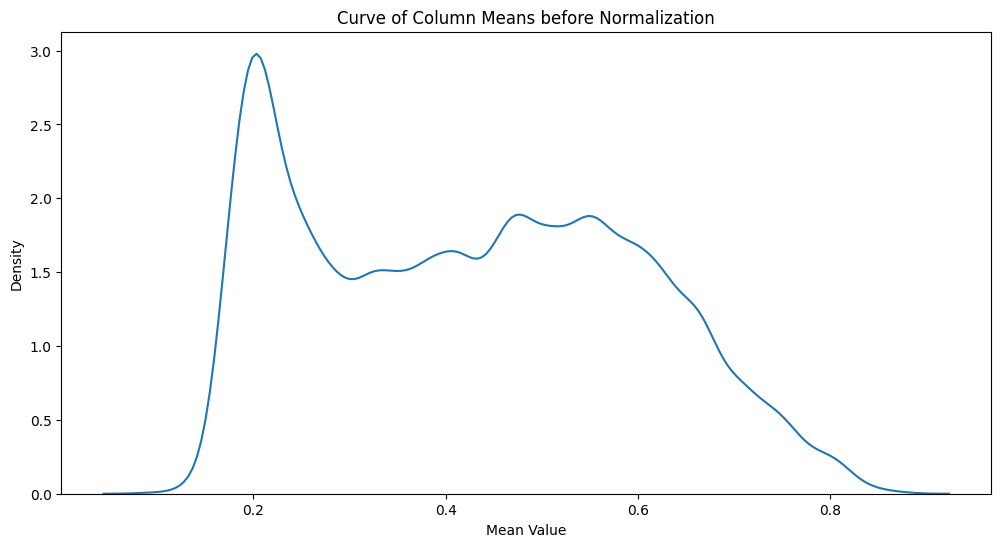

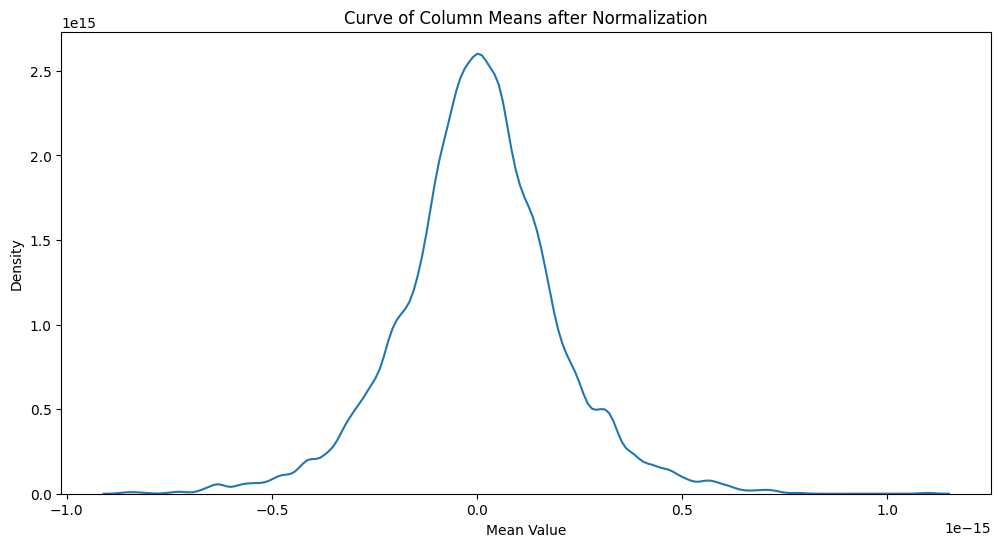

In [23]:

# change normalization method to other can test different method
meth_data.set_scaler_method("standard")
meth_data.scale_data()


In [ ]:

# change feature selection to other can test different method
meth_data.feature_selection("Boruta")

acc, report = meth_data.model_prediction()
number, features = meth_data.feature_selected()
#increase epoch may have better result at computation time cost
meth_data.neural_network_model(epochs_number=10000)
nnm_acc = meth_data.test_nnm()

In [ ]:
print("Accuracy of Random Forest is:", acc)
print("random forest model report:", report)
print("number of feature selected by boruta:", number)
print("Neural Network Accuracy", nnm_acc)


Accuracy of Random Forest is: (1.0,)
random forest model report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00        57

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158

number of feature selected by boruta: 183
Neural Network Accuracy 0.9936708860759493


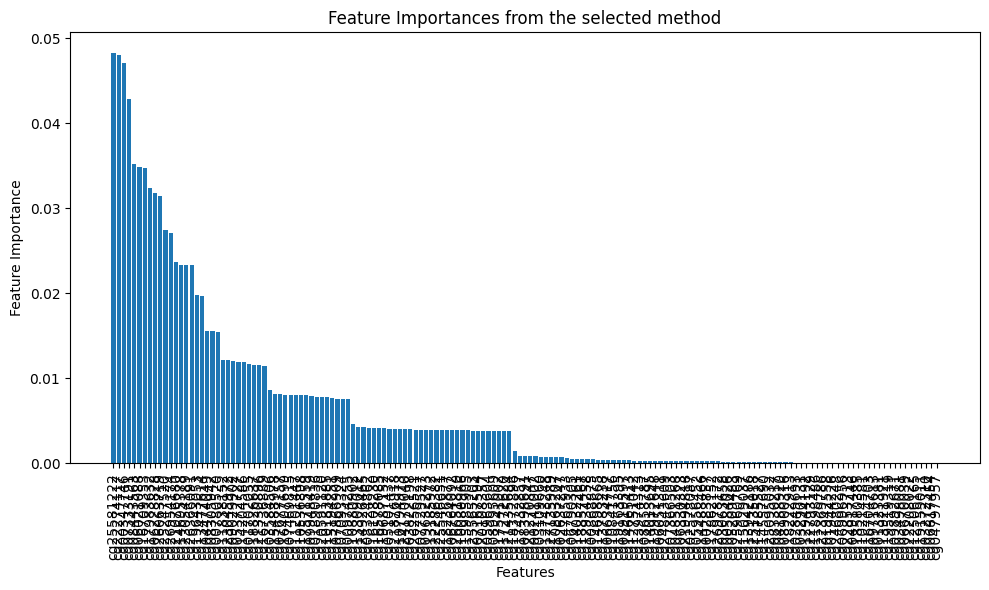

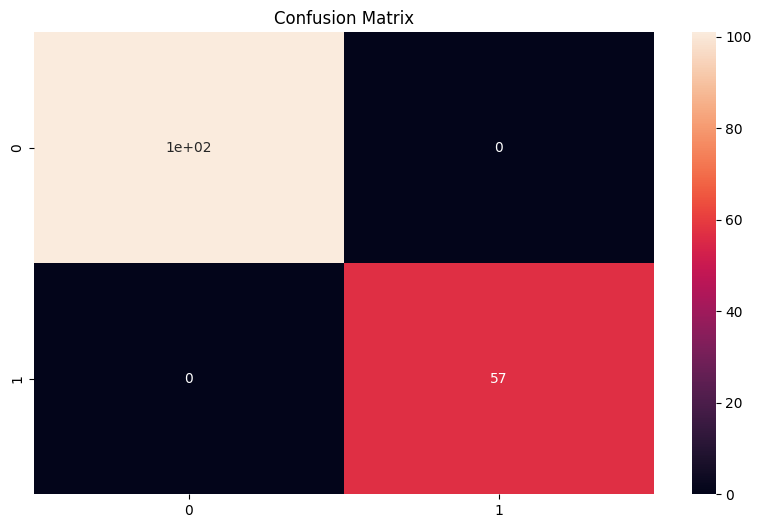

array([[101,   0],
       [  0,  57]])

In [ ]:
meth_data.visualize_importance("PNG_output/DNA_meth_boruta_feature_selected.png")
meth_data.plot_confusion_matrix("PNG_output/DNA_meth_confusion_matrix.png")

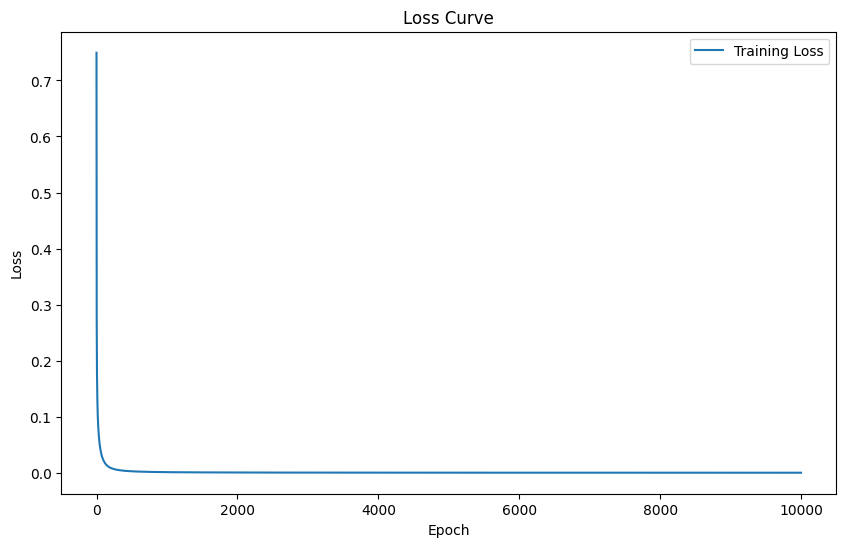

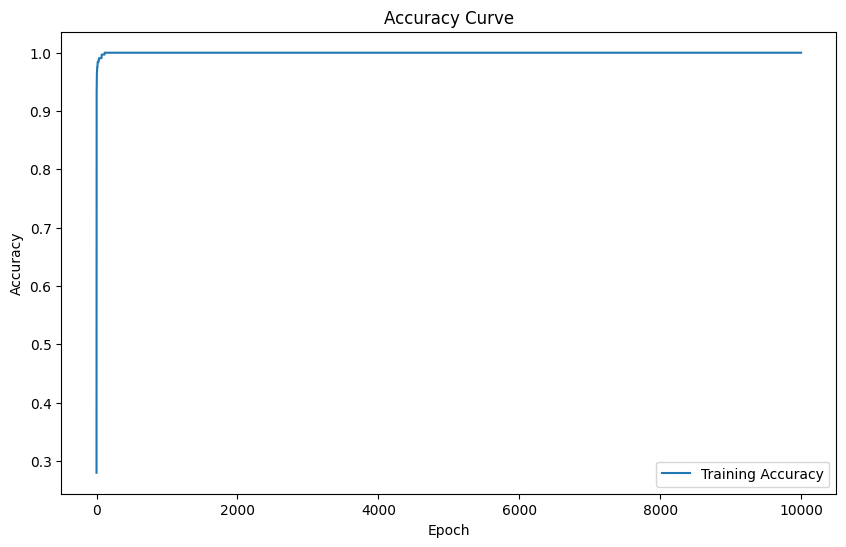

In [ ]:
meth_data.plot_nnm_result("PNG_output/")

In [ ]:
unknown_acc, unknown_report = meth_data.predict_eval(mystery_dna_meth)
print("Accuracy on the Unknown Dataset:", unknown_acc)
print("Report on the Unknown Dataset: \n", unknown_report)

Accuracy on the Unknown Dataset: 0.6
Report on the Unknown Dataset: 
               precision    recall  f1-score   support

           0       0.56      1.00      0.71       190
           1       1.00      0.20      0.33       190

    accuracy                           0.60       380
   macro avg       0.78      0.60      0.52       380
weighted avg       0.78      0.60      0.52       380



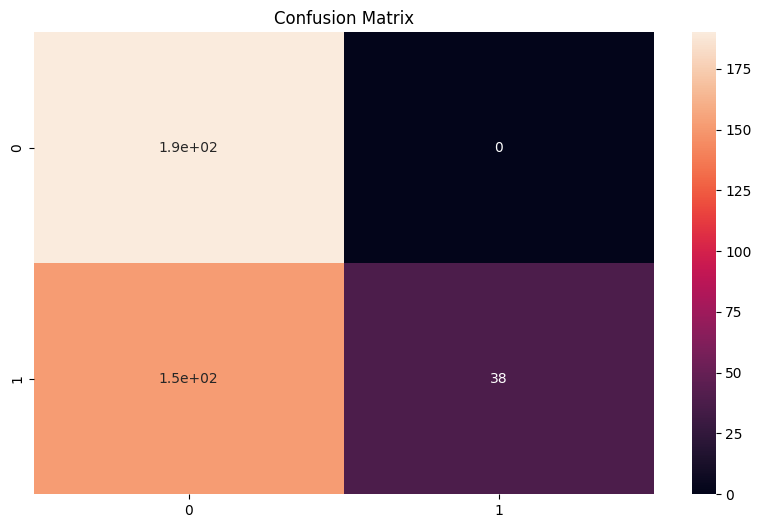

array([[190,   0],
       [152,  38]])

In [126]:
meth_data.plot_confusion_matrix("PNG_output/unknown_meth_confusion_matrix.png")

In [127]:
#increase epoch may have better result at computation time cost
unknown_nnm_acc = meth_data.test_nnm()
print("unknown Neural Network Model Accuracy: ", unknown_nnm_acc)

unknown Neural Network Model Accuracy:  0.6


## This is for GENE Expression Dataset

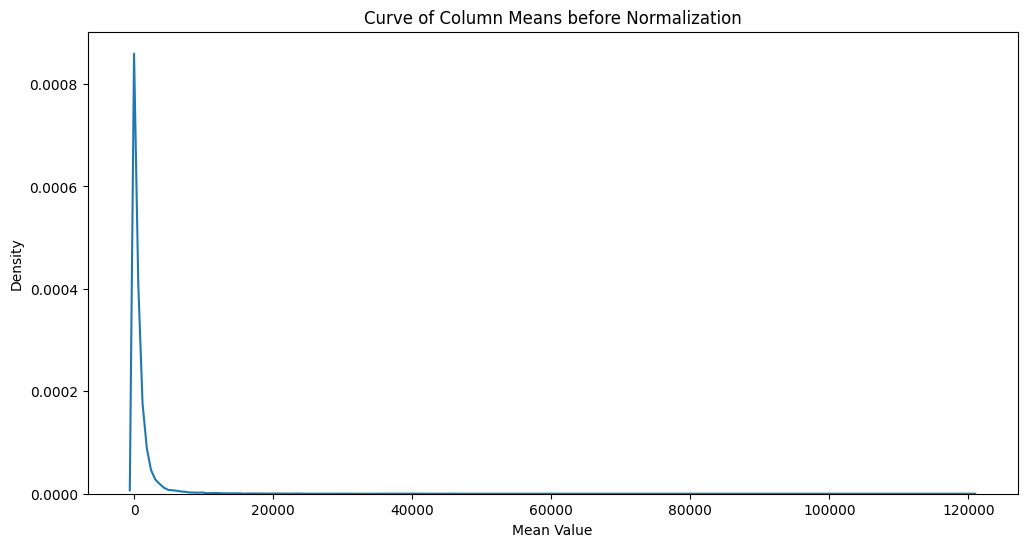

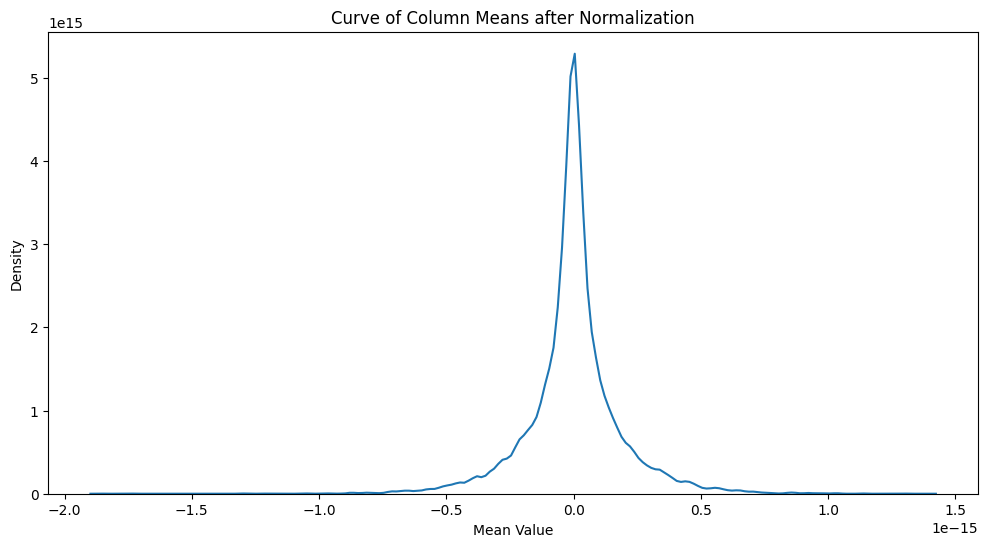

In [24]:
gene_expr_model = DataProcessor(input_data = gene_expr)
gene_expr_model.preprocessing()
gene_expr_model.set_scaler_method("standard")
gene_expr_model.scale_data()


In [ ]:

gene_expr_model.feature_selection("Boruta")

gene_acc, gene_report = gene_expr_model.model_prediction()
gene_number, gene_features = gene_expr_model.feature_selected()

gene_expr_model.neural_network_model()
gene_nnm_acc = gene_expr_model.test_nnm()

In [129]:
print("Accuracy of Random Forest Model is:", gene_acc)
print("Random Forest Model Report for Gene Expr Data:", gene_report)
print("Number of feature selected by boruta in Gene Expr Data:", gene_number)
print("Neural Network Accuracy for Gene Expr Data:", gene_nnm_acc)

Accuracy of Random Forest Model is: (0.9949748743718593,)
Random Forest Model Report for Gene Expr Data:               precision    recall  f1-score   support

           0       0.99      1.00      1.00       176
           1       1.00      0.96      0.98        23

    accuracy                           0.99       199
   macro avg       1.00      0.98      0.99       199
weighted avg       1.00      0.99      0.99       199

Number of feature selected by boruta in Gene Expr Data: 187
Neural Network Accuracy for Gene Expr Data: 1.0


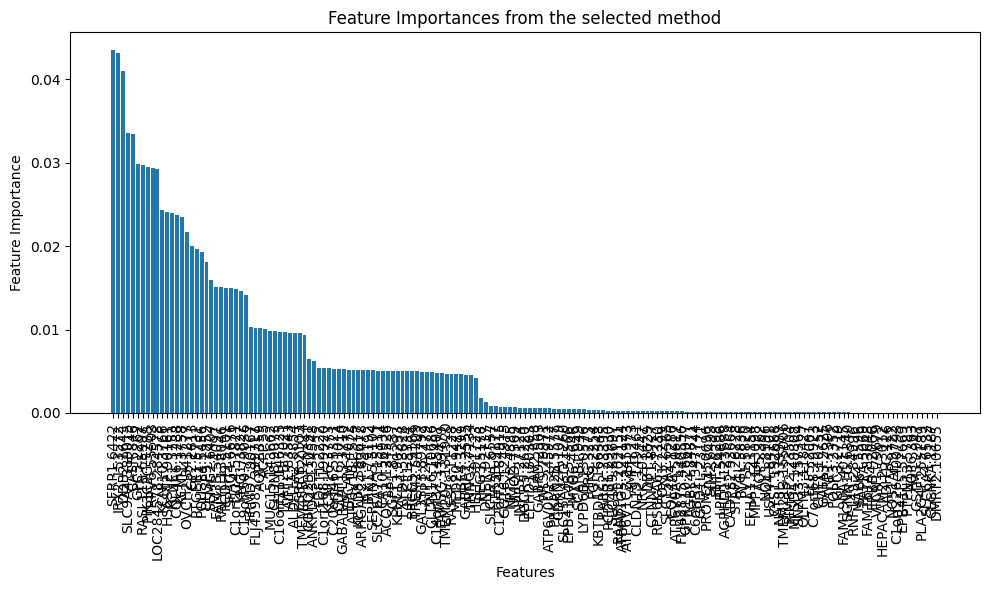

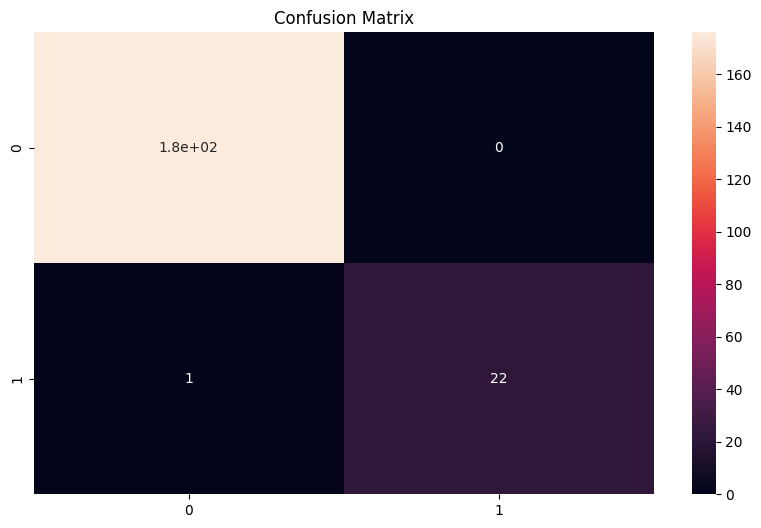

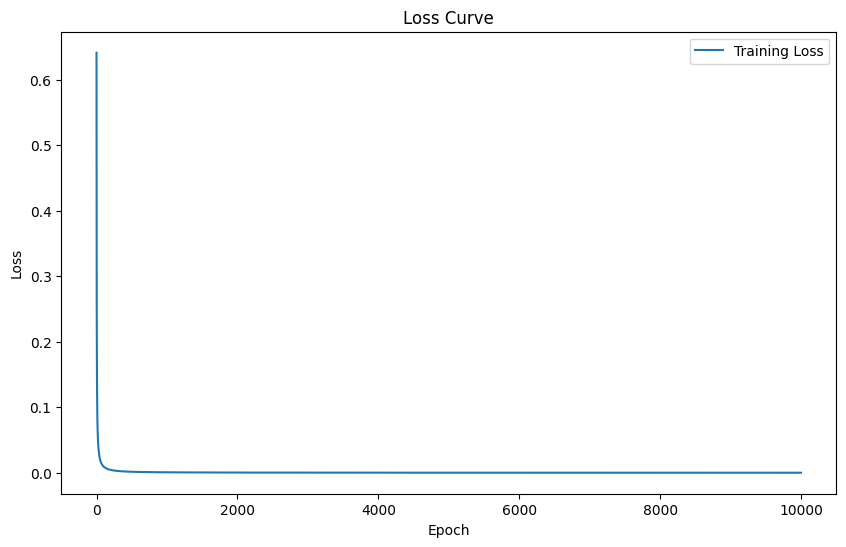

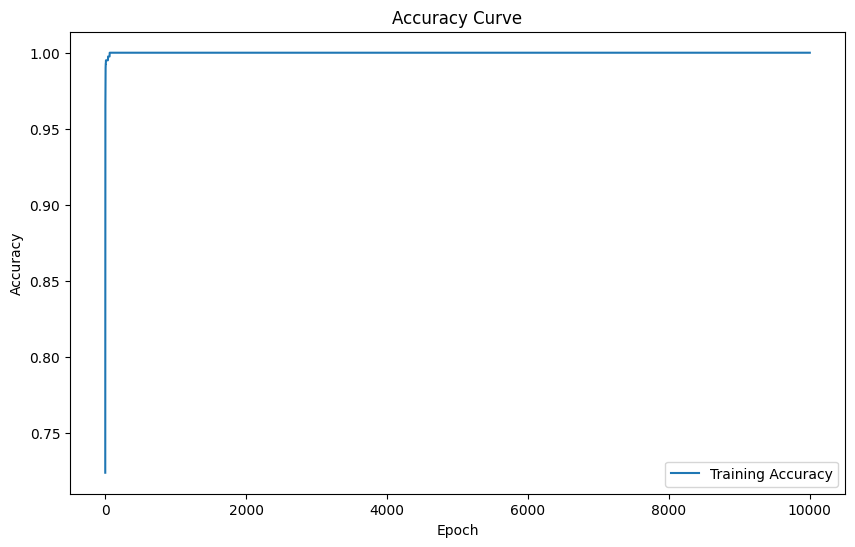

In [130]:
gene_expr_model.visualize_importance("PNG_output/gene_expr_boruta_feature_selected.png")
gene_expr_model.plot_confusion_matrix("PNG_output/gene_expr_confusion_matrix.png")
gene_expr_model.plot_nnm_result("PNG_output/")

Accuracy on Unknown gene Dataset for random forest: 0.5973684210526315
Report of RF:               precision    recall  f1-score   support

           0       0.55      1.00      0.71       190
           1       1.00      0.19      0.33       190

    accuracy                           0.60       380
   macro avg       0.78      0.60      0.52       380
weighted avg       0.78      0.60      0.52       380



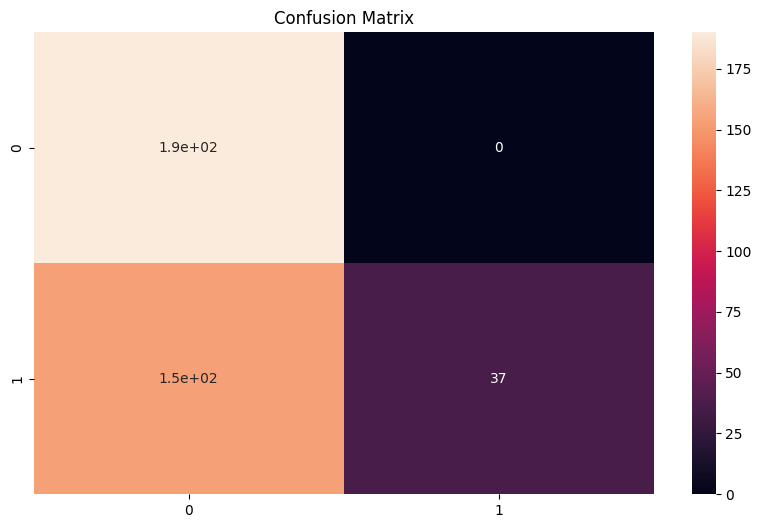

array([[190,   0],
       [153,  37]])

In [131]:
unknown_gene_acc, unknown_gene_report = gene_expr_model.predict_eval(mystery_gene_expr)
print("Accuracy on Unknown gene Dataset for random forest:", unknown_gene_acc)
print("Report of RF:", unknown_gene_report)
gene_expr_model.plot_confusion_matrix("PNG_output/unknown_gene_expr_confusion_matrix.png")

In [132]:
unknown_gene_nnm_acc = gene_expr_model.test_nnm()
print("Unknown Neural Network Model Accuracy on Gene Data:", unknown_gene_nnm_acc)

Unknown Neural Network Model Accuracy on Gene Data: 0.7368421052631579


In [ ]:
gene_expr_model.set_scaler_method()